# Clustering examples. 

Several clustering techniques are applied to see how they work.   
It is a simple example to ilustrate the usage of clustering analysis and how to use some of the implemented methods.   

You can find the data in gapminder website: https://www.gapminder.org/data/. It contains the information for each country about the Corruption Perception Index. Which is a measure of how corrupted is the country. Higher values correspond with less corruption.

## Data Cleaning

In this part we show how the data is and analyze if there are any NAs values, after make decisions of what to do with the missing values.  


In [94]:
import pandas as pd
import matplotlib.pyplot as plt

#load data
df = pd.read_csv('corruption_perception_index_cpi.csv')
df.head()

,country,2012,2013,2014,2015,2016,2017
0,Afghanistan,8.0,8.0,12.0,11.0,15.0,15
1,Albania,33.0,31.0,33.0,36.0,39.0,38
2,Algeria,34.0,36.0,36.0,36.0,34.0,33
3,Angola,22.0,23.0,19.0,15.0,18.0,19
4,Argentina,35.0,34.0,34.0,32.0,36.0,39


In [95]:
#The columns are the country and the value for the index for each year. 
print(df.columns)

Index(['country', '2012', '2013', '2014', '2015', '2016', '2017'], dtype='object')


In [3]:
#Check NAs values
print(df.isnull().sum())
print(df.shape)

country     0
2012        5
2013        4
2014        6
2015       12
2016        4
2017        0
dtype: int64
(177, 7)


There are some years that have missing information. As the missing values are not too much. We can fill them with the mean for each column. 

In [96]:
for col in df.columns[1:]:
    df[col].fillna(df[col].mean(), inplace=True)
print(df.isnull().sum())

country    0
2012       0
2013       0
2014       0
2015       0
2016       0
2017       0
dtype: int64


# K means
* The function elbow test is implemented in order to get the optimal amount of clusters
* Identify the predictors: you need to identify which are the columns to be input for the algorithm. Since it is based on distance, it does not accept the variable 'country'. So, the predictors would be the values other variables.
    The country variable will be used at then end, to know how these countries are grouped by the algorithm. 
    Thus, the variable country is not used to execute the model. 
* Once defined the input for the model, it is necessary to calculate the number of clusters by calling the function elbow test.
* After, we can execute the KMeans model and make the prediction for the clusters  
* Plot the clusters: we can do this by merging the dataset with the geopandas datasets which contains the geometry.   

**Observation**   
Kmeans can return different clusters because it is based on randomness. Therefore, we set a seeed by random_state variable when creating the model.

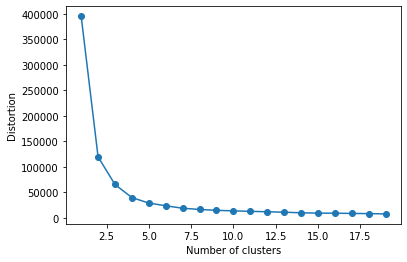

4


In [97]:
import numpy as np
from sklearn.cluster import KMeans
from kneed import KneeLocator

def elbow_test(df, n_init, max_clusters, max_iter):
    distortions = []
    for i in range(1, max_clusters):
        km = KMeans(
            n_clusters=i, init='random',
            n_init=n_init, max_iter=max_iter,
            tol=1e-04, random_state=0
        )
        km.fit(df)
        distortions.append(km.inertia_)

    plt.plot(range(1, max_clusters), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()
    
    kn = KneeLocator(
        range(1, max_clusters),
        distortions,
        curve='convex',
        direction='decreasing',
        interp_method='interp1d',
    )
    return kn.knee
predictors = df[df.columns[1:]]
n_clusters = elbow_test(predictors, 10, 20, 300)
print(n_clusters)

We can see from the graph that the gap point is at 4. It happen when there is not much difference on the distortion. So, we are ready to create the model and execute it. 

In [98]:
km = KMeans(n_clusters=n_clusters, random_state=0)
y_km = km.fit_predict(predictors)
#
df['cluster'] = km.labels_
import geopandas
from matplotlib import cm

#merge with geopandas dataset - merge left just to detect if some of the names is different for the country column in dataframe
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
merged_inner = pd.merge(left=world, right=df, left_on='name',right_on='country', how='left')

print('Merged shape: ', merged_inner.shape)
print('Total countries: ', len(df.country.unique()))

#we see that all the countries in df are in the world, but not all from world are in df. So, we remove those 
merged_inner.dropna(inplace=True)
print('final shape: ',merged_inner.shape)

Merged shape:  (177, 14)
Total countries:  177
final shape:  (147, 14)


## Visualize clusters
Finally, we can plot the clusters and make some conclusions.
From the graph, we can see as we expect that most of South America countries have low CPI, which means that are corrupt. 
You can see that this example is very simple, and tells you obvious things, but image what we can conclude if we combine this information with other variables. 

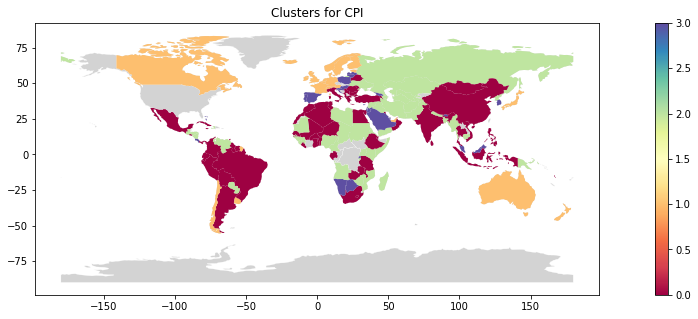

In [92]:
cmap = cm.get_cmap('Spectral')
ax = world.plot(figsize=(20,5), linewidth=0.25, edgecolor='white', color='lightgrey')
ax.set_title('Clusters for CPI')
merged_inner.plot(column='cluster', legend=True, ax=ax, cmap=cmap)